# Malicious Domain Dataset - Multi-layer Perceptron Classifier

In [41]:
import pandas as pd

# Load preprocessed dataset
datasource = "preprocessed.csv"
data = pd.read_csv(datasource)
data.Class.value_counts()

0    32613
1     3815
Name: Class, dtype: int64

## Resampling

As the preprocessed dataset is unbalanced, we resample to create a balanced set for training and testing.

In [42]:
from sklearn.utils import resample

sample_size = min(data.Class.value_counts())

malicious = resample(data.loc[data["Class"] == 0], replace=False, n_samples=sample_size, random_state=42)
benign = resample(data.loc[data["Class"] == 1], replace=False, n_samples=sample_size, random_state=42)

balanced = pd.concat([malicious, benign])
balanced.Class.value_counts()

X = balanced.drop(columns=["Class"])
y = balanced["Class"]

## Cross-validation

Here we assess how well an MLP classifier will generalize the dataset by performing 10-fold cross-validation.

In [43]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest

# Build pipeline to transform and fit data
stages = [
    ("scaler", StandardScaler()), # Standardize the data such that mean = 0 and variance = 1
    ("selector", SelectKBest(k=6)), # Select the k best parameters using ANOVA F-value 
    ("classifier", MLPClassifier(max_iter=500))] # Init MLP classifier

pipeline = Pipeline(stages)

# Perform cross validation using the pipeline
folds = 10
metrics = ["accuracy", "f1", "precision", "recall"]
scores = cross_validate(pipeline, X, y, scoring=metrics, cv=folds)

# Determine cross validation scores
scores = pd.DataFrame.from_dict(scores)
scores

,fit_time,score_time,test_accuracy,test_f1,test_precision,test_recall
0,5.569755,0.004144,0.963303,0.963824,0.949109,0.979003
1,5.262195,0.004651,0.965924,0.966321,0.953964,0.979003
2,5.624675,0.004327,0.975098,0.975357,0.964103,0.986877
3,5.996362,0.004537,0.960682,0.961832,0.933333,0.992126
4,4.260468,0.004381,0.956750,0.957529,0.939394,0.976378
5,6.334947,0.004734,0.965924,0.966057,0.963542,0.968586
6,6.613716,0.004871,0.968545,0.969072,0.954315,0.984293
7,6.406361,0.004621,0.961992,0.962484,0.951407,0.973822
8,6.371844,0.004685,0.975098,0.975357,0.966581,0.984293
9,7.107404,0.004592,0.981651,0.981723,0.979167,0.984293


In [44]:
scores.mean()

fit_time          5.954773
score_time        0.004554
test_accuracy     0.967497
test_f1           0.967956
test_precision    0.955491
test_recall       0.980867
dtype: float64

## Finalized Model

In [49]:
# Partition data into testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.4, random_state=42)

# Build pipeline to transform and fit data
stages = [
    ("scaler", StandardScaler()), # Standardize the data such that mean = 0 and variance = 1
    ("selector", SelectKBest(k=6)), # Select the k best parameters using ANOVA F-value 
    ("classifier", MLPClassifier(max_iter=500))] # Init MLP classifier

pipeline = Pipeline(stages)

pipeline.fit(X_train, y_train)

# Score the resulting model and determine which features were selected
score = pipeline.score(X_test, y_test)
k_features = X.columns.values[pipeline['selector'].get_support()]

print("Model accuraccy: %f" % (score))
print("Selected features: %s" % (k_features))

Model accuraccy: 0.968545
Selected features: ['StrangeCharacters' 'NumericRatio' 'VowelRatio' 'ConsonantSequence'
 'NumericSequence' 'DomainLength']


Note: For the above estimator the MLP hyperparameters were left as their default values. Using hyperparameter search methods the model could potentially be further improved.

### Visualizations

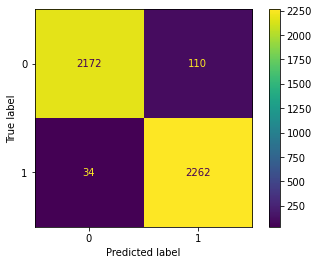

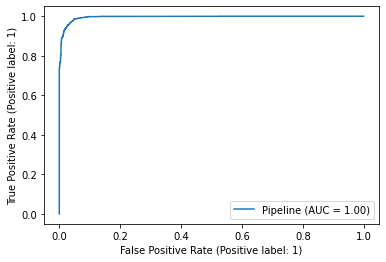

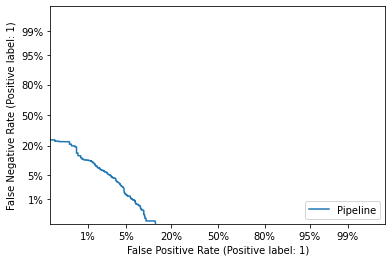

In [50]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, DetCurveDisplay

ConfusionMatrixDisplay.from_estimator(pipeline, X_test, y_test)

RocCurveDisplay.from_estimator(pipeline, X_test, y_test)

DetCurveDisplay.from_estimator(pipeline, X_test, y_test)